## Visualizing Results of the Deletion Capacity Experiment

These are the results of the deletion capacity experiment. 

At a high level, we're seeing very conservative regret bounds for the Memory Pair. This means that we're requiring large sample complexity in return for a very low deletion capacity.

It's also worth noting that our sample complexity (bar for a good learner) increases as the data wiggles more. When the Lipschitz constant and upper-bound on the Hessian are high, the sample complexity jumps and the amount of noise injected to the model becomes destabilizingly high.

Goals:
- Analyze the simulation results from the experiment runs and visualize the cumulative regret
- Focus on $\widehat{G}$ such that we can see its impact on the downstream stability of the learner
- Investigate alternative methods of privacy accounting. Can we get tigheter regret bounds such that we don't inject so much noise into the parameter estimates.


### Page-Wide Questions
- The formulas for sample complexity and deletion capacity look very similar (ie. use the $GD$ term). Why is this the case, and what does this suggest about the relationship between these two formulas? If I were to divide sample complexity by deletion capacity, it would almost look like something like a harmonic mean.
- I wonder how $\widehat{D}$ is being estimated. It looks like a lot of seeds are capping it at 10, which is a worst-case scenario. Is there something that can reduce this?

In [28]:
import pandas as pd
import numpy as np
import random
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
path = "/workspaces/unlearning-research-meta/experiments/deletion_capacity/results/grid_2025_08_11/sweep/gamma_1.0-split_0.5_q0.90_k5_relaxed_eps1.0/seed_000_synthetic_memorypair.csv"

data = pd.read_csv(path)

In [30]:
data.columns

Index(['C_hat', 'D_hat', 'G_hat', 'N_star_theory', 'P_T', 'P_T_est',
       'S_scalar', 'acc', 'accountant_type', 'base_eta_t', 'c_hat',
       'capacity_remaining', 'comparator_type', 'deletion_capacity',
       'deletions_count', 'delta_step_theory', 'delta_total',
       'drift_boost_remaining', 'drift_flag', 'eps_converted',
       'eps_step_theory', 'eta_t', 'event', 'event_id', 'event_type',
       'lambda_est', 'm_theory', 'op', 'regret', 'relaxation_factor',
       'rho_remaining', 'rho_spent', 'rho_step', 'rho_total', 'sample_id',
       'segment_id', 'sens_delete', 'sigma_step_base', 'sigma_step_theory',
       'x_norm'],
      dtype='object')

The code performs a grid search over the experiment parameters. For each seed,
1. **(Calibration.)** a `Calibrator` object draws a small sample of the data stream to estimate stream-attributes like the Lipschitz constant $L$, the upper and lower bound of the Hessian eigenvalues $C, C$, and the resulting sample complexity required to meet predefined accuracy goals.
2. **(Warmup.)** the model is trained on a stream of samples until it reaches sample complexity. This sets the model up for success when we test deletions.
3. **(Workload.)** a stream of interleaved insertions and deletions is passed to the model. It's expected to service the requests in the order they're given.

In [31]:
import os, json, glob, math
from pathlib import Path


# Deletion-Capacity EDA: distributions, boxes, timelines, correlations

This notebook helps you quickly explore high-dimensional logs exported by the deletion-capacity experiments.
It discovers numeric columns automatically, picks a subset with high coverage/variance, and produces:

- Distribution histograms
- Box plots grouped by operation (`op` or `event_type`)
- Timeline plots (regret/accuracy vs event index when available)
- ECdata comparisons (e.g., regret by op)
- Correlation matrix for the selected metrics

All figures and tables are also saved under `/eda/` so you can reuse them elsewhere.

In [ ]:
import os, glob, json, math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For nice tables in Jupyter
try:
    from ace_tools import display_dataframe_to_user as _display_data
except Exception:
    def _display_data(name, data):
        display(data)
        

In [33]:
# Update this list to point at your CSVs.
# By default we try a few common patterns from the repo structure.
DATA_GLOBS = [
    "grid_2025_08_11/sweep/*_q0.90_*/*.csv"
]

TOP_N_FEATURES = 8     # how many numeric columns to visualize
GROUP_BY_FALLBACK = "op"   # if 'op' doesn't exist, we'll try 'event_type'
RANDOM_STATE = 7

## 2) Load & preview data

In [ ]:
import os
import subprocess
import glob
from pathlib import Path

def ensure_git_lfs_data():
    """Ensure Git LFS files are pulled before attempting to read data."""
    try:
        # Check if we're in a git repository
        repo_root = Path('/workspaces/unlearning-research-meta')
        result = subprocess.run(['git', 'rev-parse', '--git-dir'], 
                              capture_output=True, text=True, cwd=repo_root)
        if result.returncode != 0:
            print("Not in a git repository, skipping LFS pull")
            return False
        
        # Check if git-lfs is available
        result = subprocess.run(['git', 'lfs', 'version'], 
                              capture_output=True, text=True, cwd=repo_root)
        if result.returncode != 0:
            print("Git LFS not available, skipping LFS pull")
            return False
            
        # Pull LFS files
        print("Pulling Git LFS files...")
        result = subprocess.run(['git', 'lfs', 'pull'], 
                              capture_output=True, text=True, cwd=repo_root)
        if result.returncode == 0:
            print("✓ Git LFS files pulled successfully")
            return True
        else:
            print(f"Git LFS pull failed: {result.stderr}")
            print("Continuing without LFS data...")
            return False
    except Exception as e:
        print(f"Error pulling Git LFS files: {e}")
        return False

def load_frames(globs):
    # Ensure LFS data is available
    ensure_git_lfs_data()
    
    # Convert relative paths to absolute paths from repo root
    repo_root = Path('/workspaces/unlearning-research-meta')
    files = []
    for g in globs:
        print(g)
        if not os.path.isabs(g):
            # Make relative paths relative to the experiments/deletion_capacity/results directory
            full_pattern = repo_root / "experiments/deletion_capacity/results" / g
        else:
            full_pattern = Path(g)
        matched_files = glob.glob(str(full_pattern))
        files.extend(matched_files)
        print(f"Pattern: {full_pattern}")
        print(f"  Matched {len(matched_files)} files")
    
    files = sorted(set(files))
    print(f"\nLooking for files matching: {globs}")
    print(f"Found {len(files)} total files")
    
    if not files:
        # Try to list available files to help debug
        results_dir = repo_root / "experiments/deletion_capacity/results"
        if results_dir.exists():
            print(f"\nAvailable CSV files in {results_dir}:")
            csv_files = list(results_dir.rglob("*.csv"))
            for file in csv_files[:10]:  # Show first 10 files
                print(f"  {file.relative_to(results_dir)}")
            if len(csv_files) > 10:
                print(f"  ... and {len(csv_files) - 10} more files")
        raise FileNotFoundError(f"No CSV files found. Update DATA_GLOBS. Tried: {globs}")
    
    frames = []
    for p in files:
        try:
            # Check if file is a Git LFS pointer
            with open(p, 'rb') as f:
                first_line = f.readline().decode('utf-8', errors='ignore')
                if first_line.startswith('version https://git-lfs.github.com/spec/'):
                    print(f"[warn] {p} appears to be a Git LFS pointer file, not actual data")
                    continue
            
            data = pd.read_csv(p, low_memory=False)
            data["__source__"] = str(Path(p).relative_to(repo_root))
            data["seed"] = data["__source__"].str.split("_", expand = True)[11]

            frames.append(data)
            print(f"✓ Loaded {Path(p).name} ({data.shape[0]} rows)")
        except Exception as e:
            print(f"[warn] failed to read {Path(p).name}: {e}")
    
    if not frames:
        raise RuntimeError("All CSV reads failed. This might indicate Git LFS files weren't properly pulled.")
    
    return pd.concat(frames, ignore_index=True, sort=False)

# Update DATA_GLOBS to use paths relative to experiments/deletion_capacity/results
DATA_GLOBS = [
    "grid_*/sweep/*_zcdp_eps1.0/*memorypair.csv"
]

# Rest of your existing code...
data = load_frames(DATA_GLOBS)

print(f"\nLoaded shape: {data.shape}")
print("First 10 columns:", list(data.columns[:10]))
print("Total columns:", len(data.columns))
_display_data("Sample rows (head 10)", data.head(10))


Pulling Git LFS files...
✓ Git LFS files pulled successfully
grid_*/sweep/*_zcdp_eps1.0/*memorypair.csv
Pattern: /workspaces/unlearning-research-meta/experiments/deletion_capacity/results/grid_*/sweep/*_zcdp_eps1.0/*memorypair.csv
  Matched 160 files

Looking for files matching: ['grid_*/sweep/*_zcdp_eps1.0/*memorypair.csv']
Found 160 total files
✓ Loaded seed_000_synthetic_memorypair.csv (1400 rows)
✓ Loaded seed_001_synthetic_memorypair.csv (1003 rows)
✓ Loaded seed_002_synthetic_memorypair.csv (2531 rows)
✓ Git LFS files pulled successfully
grid_*/sweep/*_zcdp_eps1.0/*memorypair.csv
Pattern: /workspaces/unlearning-research-meta/experiments/deletion_capacity/results/grid_*/sweep/*_zcdp_eps1.0/*memorypair.csv
  Matched 160 files

Looking for files matching: ['grid_*/sweep/*_zcdp_eps1.0/*memorypair.csv']
Found 160 total files
✓ Loaded seed_000_synthetic_memorypair.csv (1400 rows)
✓ Loaded seed_001_synthetic_memorypair.csv (1003 rows)
✓ Loaded seed_002_synthetic_memorypair.csv (2531 row

,C_hat,D_hat,G_hat,N_star_theory,P_T,P_T_est,S_scalar,acc,accountant_type,base_eta_t,...,rho_spent,rho_step,rho_total,sample_id,segment_id,sens_delete,sigma_step_theory,x_norm,__source__,seed
0,NaN,NaN,NaN,NaN,0.0,0.0,906.297022,6.543379,zcdp,0.033217,...,NaN,NaN,NaN,linear_000000,0,NaN,NaN,4.600798,experiments/deletion_capacity/results/grid_202...,000
1,NaN,NaN,NaN,NaN,0.0,0.0,1278.530198,4.574331,zcdp,0.027967,...,NaN,NaN,NaN,linear_000001,0,NaN,NaN,4.217741,experiments/deletion_capacity/results/grid_202...,000
2,NaN,NaN,NaN,NaN,0.0,0.0,1680.653783,4.830948,zcdp,0.024393,...,NaN,NaN,NaN,linear_000002,0,NaN,NaN,4.150949,experiments/deletion_capacity/results/grid_202...,000
3,NaN,NaN,NaN,NaN,0.0,0.0,1888.337220,2.873770,zcdp,0.023012,...,NaN,NaN,NaN,linear_000003,0,NaN,NaN,5.014745,experiments/deletion_capacity/results/grid_202...,000
4,NaN,NaN,NaN,NaN,0.0,0.0,1924.448413,1.471433,zcdp,0.022795,...,NaN,NaN,NaN,linear_000004,0,NaN,NaN,4.083950,experiments/deletion_capacity/results/grid_202...,000
5,NaN,NaN,NaN,NaN,0.0,0.0,2569.114742,4.734167,zcdp,0.019729,...,NaN,NaN,NaN,linear_000005,0,NaN,NaN,5.363198,experiments/deletion_capacity/results/grid_202...,000
6,NaN,NaN,NaN,NaN,0.0,0.0,2570.233046,0.222420,zcdp,0.019725,...,NaN,NaN,NaN,linear_000006,0,NaN,NaN,4.754518,experiments/deletion_capacity/results/grid_202...,000
7,NaN,NaN,NaN,NaN,0.0,0.0,2639.399709,2.186443,zcdp,0.019465,...,NaN,NaN,NaN,linear_000007,0,NaN,NaN,3.803735,experiments/deletion_capacity/results/grid_202...,000
8,NaN,NaN,NaN,NaN,0.0,0.0,2692.688634,2.150634,zcdp,0.019271,...,NaN,NaN,NaN,linear_000008,0,NaN,NaN,3.394313,experiments/deletion_capacity/results/grid_202...,000
9,NaN,NaN,NaN,NaN,0.0,0.0,3915.808335,6.263247,zcdp,0.015980,...,NaN,NaN,NaN,linear_000009,0,NaN,NaN,5.583865,experiments/deletion_capacity/results/grid_202...,000


In [57]:
# display a few sample IDs
sample_ids = df.sample_id.tolist()[:5]
print("Sample IDs:", sample_ids)

# display a few segment IDs
segment_ids = df.segment_id.tolist()[:5]
print("Segment IDs:", segment_ids)

Sample IDs: ['linear_000000', 'linear_000001', 'linear_000002', 'linear_000003', 'linear_000004']
Segment IDs: [0, 0, 0, 0, 0]


## Segment IDs and Possible Data Loader Issues

The `segment_id` field isn't being populated, which indicates that there is some bud in the code.

I think this may have to specifically do with the data loaders. The segment ID is supposed to be emitted during that point, but it isn't. This may also have impacted the experiment because most of the loaders exhausted their deletion capacity before the experiment could conclude. 

In [58]:
# segment ID value counts
segment_counts = df.segment_id.value_counts()
print("Segment ID Counts:")
print(segment_counts)

Segment ID Counts:
segment_id
0    2016934
Name: count, dtype: int64


In [47]:
sample_data = data[data.sample_id == "linear_000002"]
sample_data

,C_hat,D_hat,G_hat,N_star_theory,P_T,P_T_est,S_scalar,acc,accountant_type,base_eta_t,...,rho_remaining,rho_spent,rho_step,rho_total,sample_id,segment_id,sens_delete,sigma_step_base,sigma_step_theory,x_norm
2,NaN,NaN,NaN,NaN,0.0,0.0,1680.653783,4.830948,relaxed,0.024393,...,NaN,NaN,NaN,NaN,linear_000002,0,NaN,NaN,NaN,4.150949


In [46]:
data.columns

Index(['C_hat', 'D_hat', 'G_hat', 'N_star_theory', 'P_T', 'P_T_est',
       'S_scalar', 'acc', 'accountant_type', 'base_eta_t', 'c_hat',
       'capacity_remaining', 'comparator_type', 'deletion_capacity',
       'deletions_count', 'delta_step_theory', 'delta_total',
       'drift_boost_remaining', 'drift_flag', 'eps_converted',
       'eps_step_theory', 'eta_t', 'event', 'event_id', 'event_type',
       'lambda_est', 'm_theory', 'op', 'regret', 'relaxation_factor',
       'rho_remaining', 'rho_spent', 'rho_step', 'rho_total', 'sample_id',
       'segment_id', 'sens_delete', 'sigma_step_base', 'sigma_step_theory',
       'x_norm'],
      dtype='object')

In [56]:
# grab first 5 columns
data.iloc[:, :5]
data.iloc[:, 5:10]

,P_T_est,S_scalar,acc,accountant_type,base_eta_t
0,0.0,906.297022,6.543379,relaxed,0.033217
1,0.0,1278.530198,4.574331,relaxed,0.027967
2,0.0,1680.653783,4.830948,relaxed,0.024393
3,0.0,1888.337220,2.873770,relaxed,0.023012
4,0.0,1924.448413,1.471433,relaxed,0.022795
...,...,...,...,...,...
509,0.0,122805.670170,272.724089,relaxed,0.002854
510,0.0,130015.240352,20.933456,relaxed,0.002773
511,0.0,130015.575089,0.159041,relaxed,0.002773
512,0.0,137167.416961,13.304069,relaxed,0.002700


## 3) Discover numeric columns & score them by coverage/variance

In [ ]:
# Columns we consider IDs / metadata and generally exclude from metrics
ID_LIKE = {
    "grid_id","seed","event","event_id","segment_id","sample_id","__source__",
    "dataset","accountant","accountant_type","comparator_type","algo","alphas",
    "out_dir"
}

# Detect numeric columns
numeric_cols = [c for c in data.columns 
                if c not in ID_LIKE 
                and pd.api.types.is_numeric_dtype(data[c])]

# Drop columns that are entirely NaN or constant
def is_constant(series):
    s = series.dropna()
    if s.empty: 
        return True
    return s.nunique(dropna=True) <= 1

numeric_cols = [c for c in numeric_cols if not is_constant(data[c])]

# Score columns: higher non-null fraction and higher std are better
scores = []
for c in numeric_cols:
    col = data[c]
    nonnull_frac = col.notna().mean()
    std = float(col.dropna().std()) if nonnull_frac > 0 else 0.0
    scores.append((c, nonnull_frac, std))

score_data = pd.DataFrame(scores, columns=["column","nonnull_frac","std"]).sort_values(
    by=["nonnull_frac","std"], ascending=[False, False]
).reset_index(drop=True)

_display_data("Numeric columns ranked by coverage & std", score_data.head(30))

# Select top-N features
selected = score_data.head(TOP_N_FEATURES)["column"].tolist()
print("Selected features:", selected)

# drop unselected columns but include IDs
data.drop(columns=[c for c in data.columns if c not in selected + list(ID_LIKE)], inplace=True)


,column,nonnull_frac,std
0,S_scalar,1.000000,2.852833e+07
1,regret,1.000000,2.034941e+06
2,lambda_est,1.000000,1.415928e+00
3,x_norm,1.000000,7.035517e-01
4,base_eta_t,1.000000,2.063419e-03
5,eta_t,1.000000,2.063419e-03
6,acc,0.999921,6.464557e+01
7,N_star_theory,0.960336,1.651195e+05
8,G_hat,0.960336,1.631789e+01
9,D_hat,0.960336,6.293758e-01


Selected features: ['S_scalar', 'regret', 'lambda_est', 'x_norm', 'base_eta_t', 'eta_t', 'acc', 'N_star_theory']


## 4) Distributions: histograms for selected features

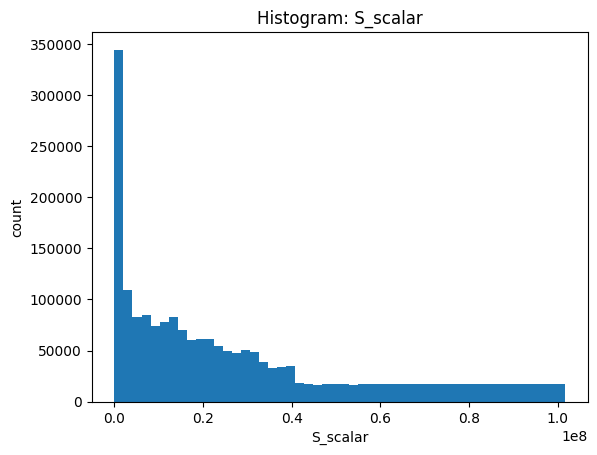

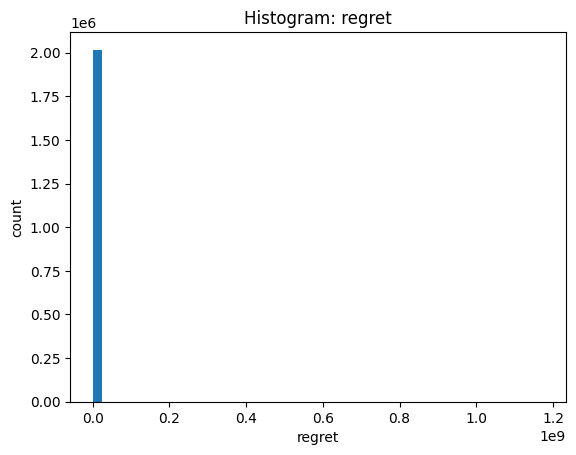

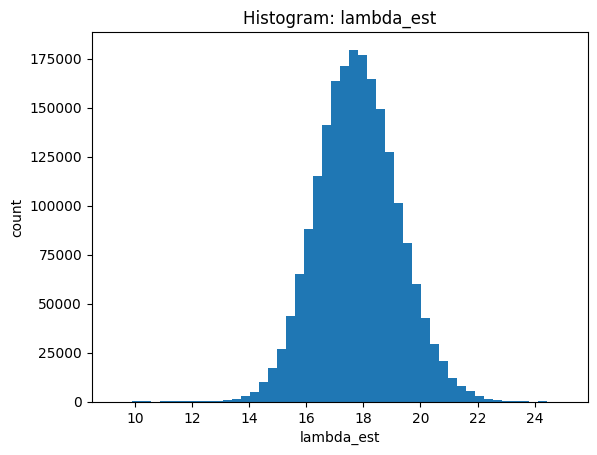

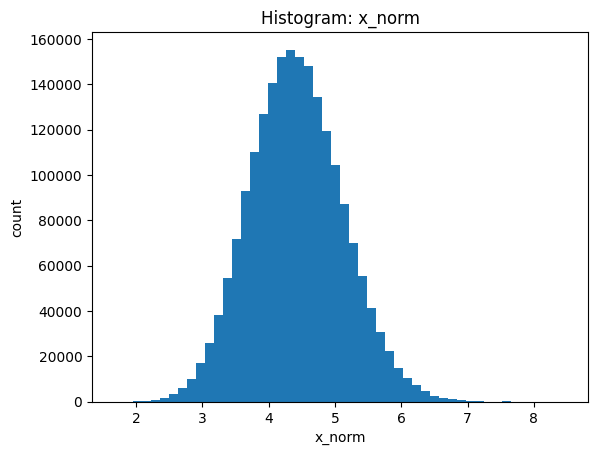

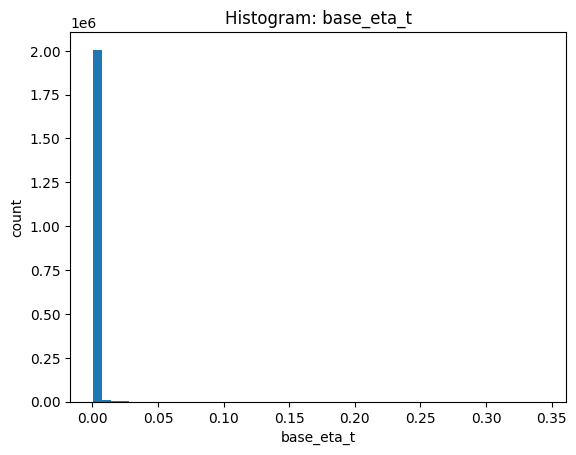

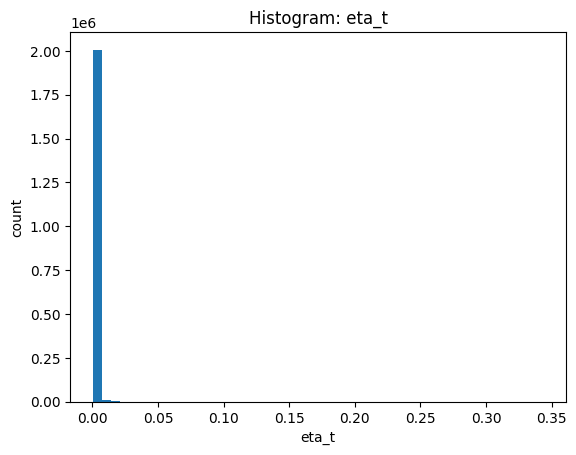

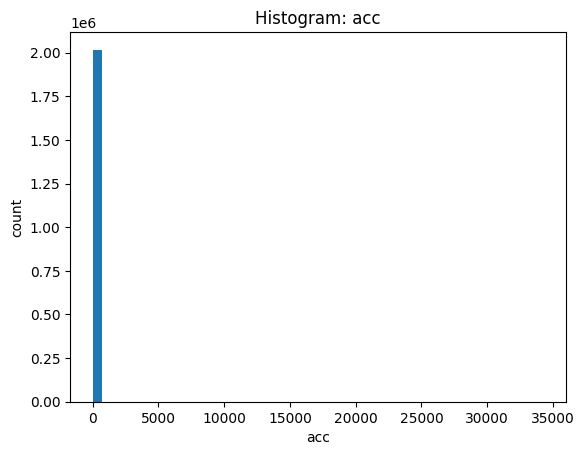

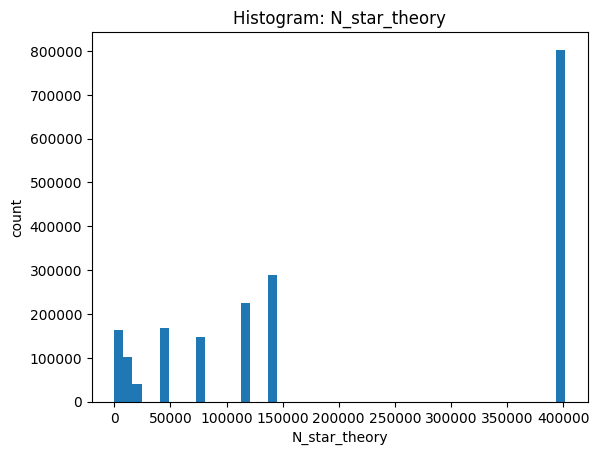

In [ ]:
for c in selected:
    s = data[c].dropna().astype(float)
    if s.empty:
        continue
    plt.figure()
    plt.hist(s, bins=50)
    plt.title(f"Histogram: {c}")
    plt.xlabel(c); plt.ylabel("count")


## Distributions of the Quantitative Data

`lambda_est` is the estimated curvature bound of the L-BFGS optimization. I noticed it's one of the few fields with a somewhat normal distribution, so I wanted to zoom in on that. Are we controlling for $\lambda_{est}$ in the data-generating process or is this something to pay attention to?

`x_norm` is the gradient of the loss? I'm not sure actually.

## 5) Box plots by operation (`op` or `event_type`)

/tmp/ipykernel_48365/1170580744.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals, labels=groups, showfliers=False)
/tmp/ipykernel_48365/1170580744.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals, labels=groups, showfliers=False)
/tmp/ipykernel_48365/1170580744.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals, labels=groups, showfliers=False)
/tmp/ipykernel_48365/1170580744.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.box

/tmp/ipykernel_48365/1170580744.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals, labels=groups, showfliers=False)
/tmp/ipykernel_48365/1170580744.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals, labels=groups, showfliers=False)
/tmp/ipykernel_48365/1170580744.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals, labels=groups, showfliers=False)
/tmp/ipykernel_48365/1170580744.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.box

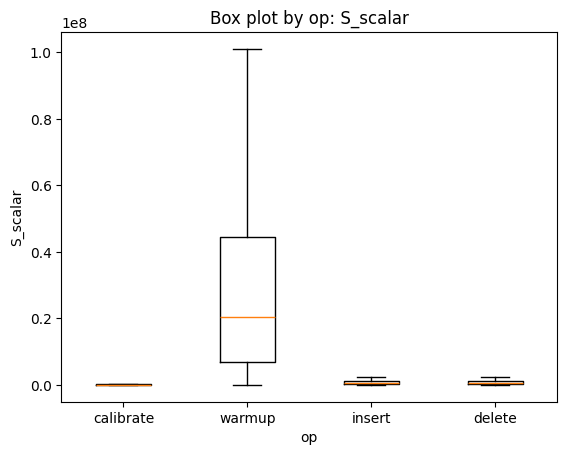

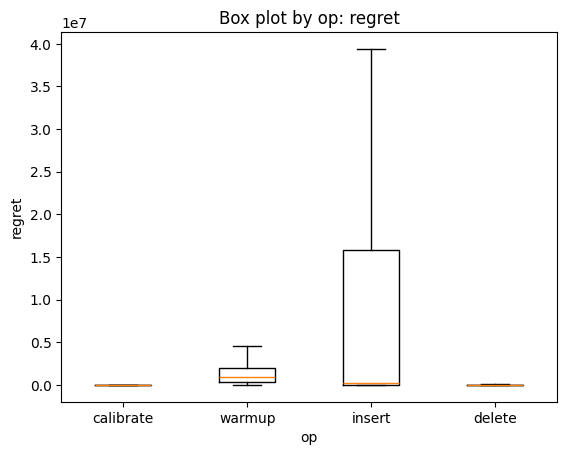

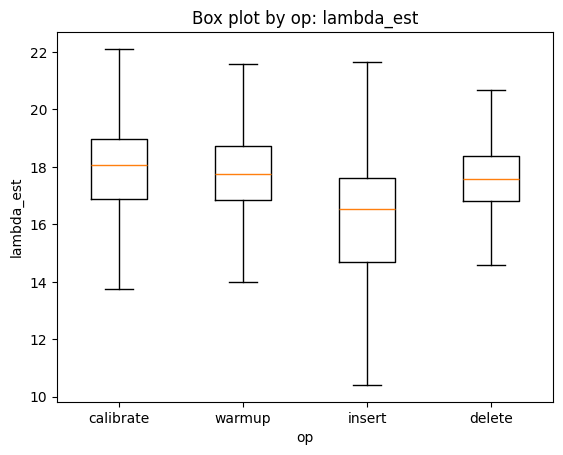

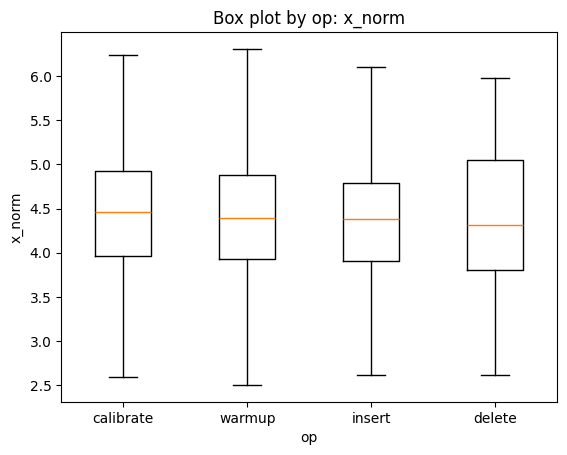

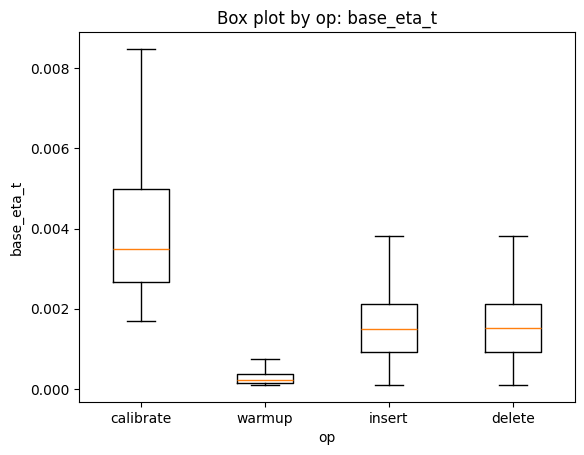

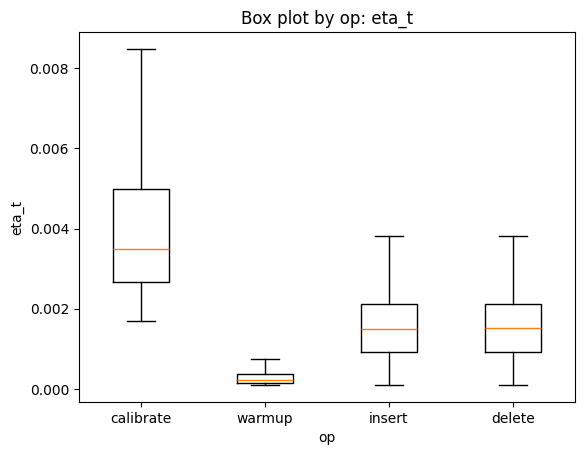

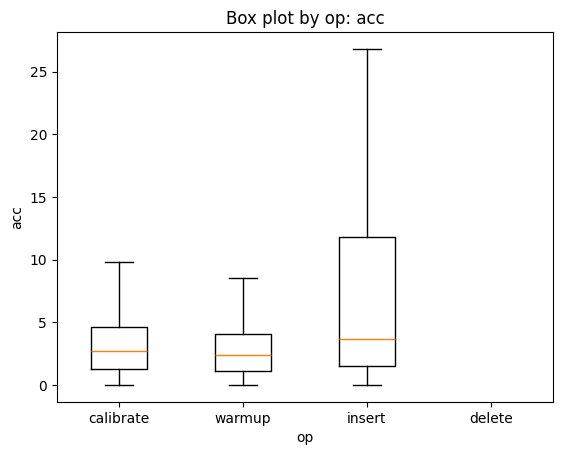

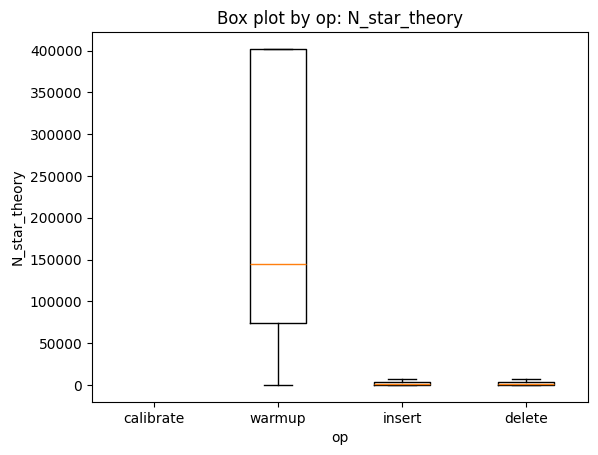

In [ ]:
group_col = None
if "op" in data.columns:
    group_col = "op"
elif "event_type" in data.columns:
    group_col = "event_type"

if group_col:
    groups = [g for g in data[group_col].dropna().unique().tolist() if str(g) != "nan"]
    for c in selected:
        vals = [data.loc[data[group_col]==g, c].dropna().values for g in groups]
        # skip if everything is empty
        if all(len(v)==0 for v in vals):
            continue
        plt.figure()
        plt.boxplot(vals, labels=groups, showfliers=False)
        plt.title(f"Box plot by {group_col}: {c}")
        plt.xlabel(group_col); plt.ylabel(c)
else:
    print("No 'op' or 'event_type' column found; skipping box plots.")

## 6) Timelines: regret/accuracy over event index (if present)

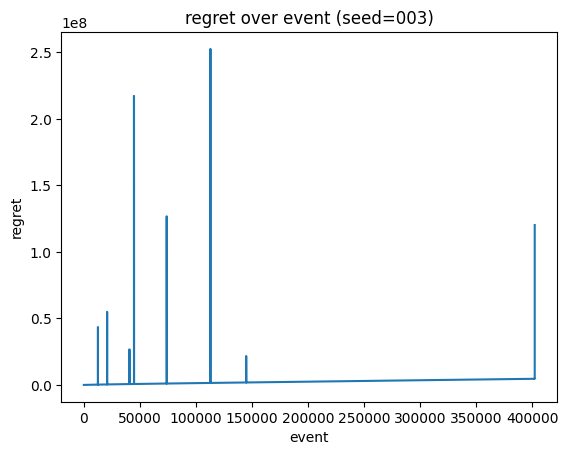

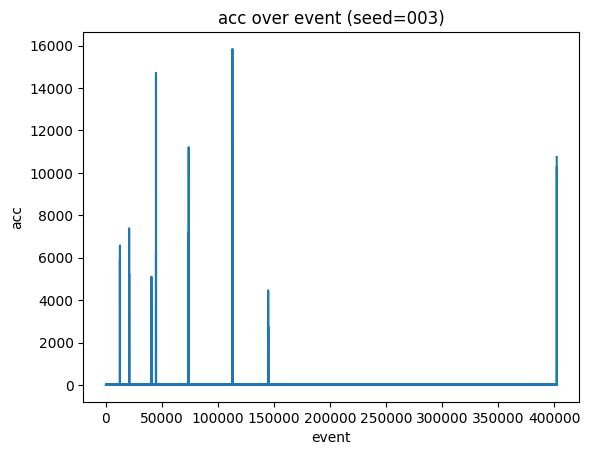

In [ ]:
# Choose a frequent (grid_id, seed) combo if those columns exist
def pick_one_slice(data):
    cols = data.columns
    if "grid_id" in cols and "seed" in cols:
        key_counts = data.groupby(["grid_id","seed"]).size().sort_values(ascending=False)
        if not key_counts.empty:
            return key_counts.index[0]
    elif "seed" in cols:
        key_counts = data.groupby(["seed"]).size().sort_values(ascending=False)
        if not key_counts.empty:
            return (None, key_counts.index[0])
    return (None, None)

gid, sd = pick_one_slice(data)

def plot_series(col, title_suffix=""):
    s = data.copy()
    if gid is not None and "grid_id" in s.columns:
        s = s[s["grid_id"]==gid]
    if sd is not None and "seed" in s.columns:
        s = s[s["seed"]==sd]
    # Use event or event_id as x if present; otherwise default to index order
    if "event" in s.columns:
        s = s.sort_values("event")
        x = s["event"].values
    elif "event_id" in s.columns:
        s = s.sort_values("event_id")
        x = s["event_id"].values
    else:
        s = s.reset_index(drop=True)
        x = s.index.values
    if col not in s.columns or s[col].dropna().empty:
        return False
    y = s[col].astype(float).values
    plt.figure()
    plt.plot(x, y)
    xlabel = "event" if "event" in s.columns else ("event_id" if "event_id" in s.columns else "index")
    plt.xlabel(xlabel); plt.ylabel(col)
    ttl = f"{col} over {xlabel}"
    if gid is not None and "grid_id" in data.columns:
        ttl += f" (grid_id={gid})"
    if sd is not None and "seed" in data.columns:
        ttl += f" (seed={sd})"
    plt.title(ttl + title_suffix)
    return True

plotted_any = False
for metric in ["regret","acc","sigma_step_theory","eps_converted","rho_spent"]:
    if metric in data.columns:
        ok = plot_series(metric)
        plotted_any = plotted_any or ok

if not plotted_any:
    print("No suitable timeline metrics found (looked for regret/acc/sigma_step_theory/eps_converted/rho_spent).")

## 7) ECdata: compare a key metric by operation

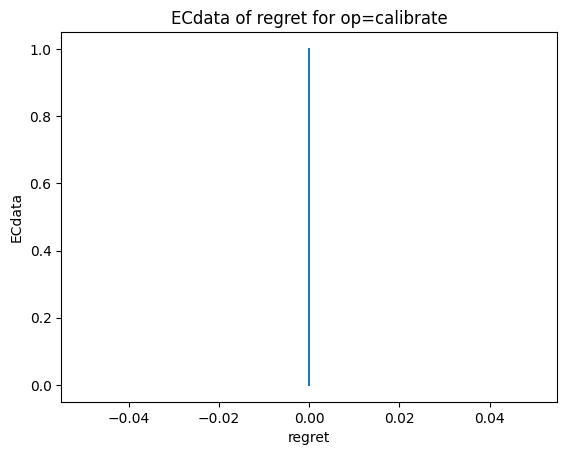

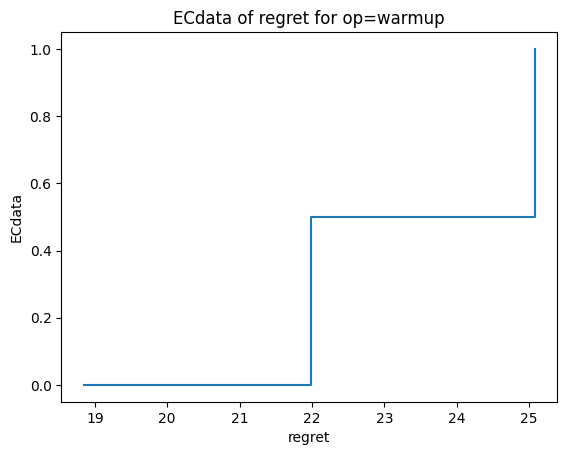

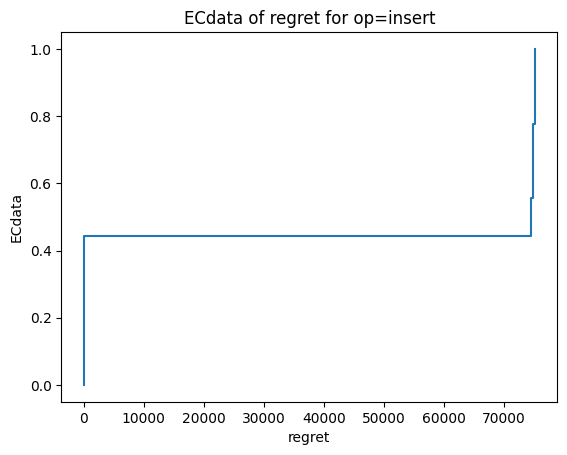

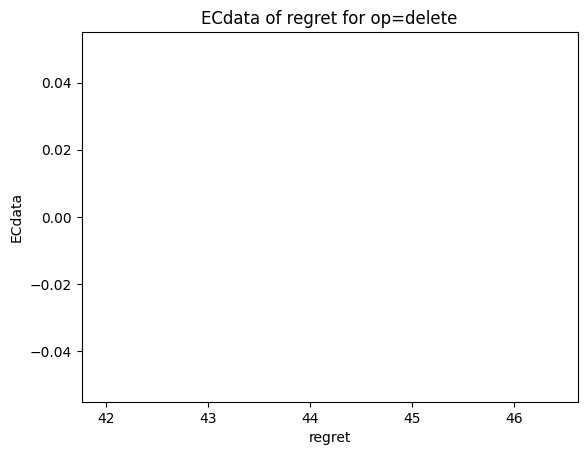

In [41]:
# We'll try 'regret' first, else fall back to the first selected column
metric = "regret" if "regret" in data.columns else (selected[0] if selected else None)
if metric is not None and group_col is not None:
    groups = [g for g in data[group_col].dropna().unique().tolist() if str(g) != "nan"]
    for g in groups:
        s = data.loc[data[group_col]==g, metric].dropna().astype(float).values
        if s.size == 0: 
            continue
        s = np.sort(s)
        y = np.linspace(0, 1, s.size, endpoint=True)
        plt.figure()
        plt.step(s, y, where="post")
        plt.xlabel(metric); plt.ylabel("ECdata")
        plt.title(f"ECdata of {metric} for {group_col}={g}")
else:
    print("Skipping ECdatas (missing metric or group column).")

## 8) Correlation matrix for selected features

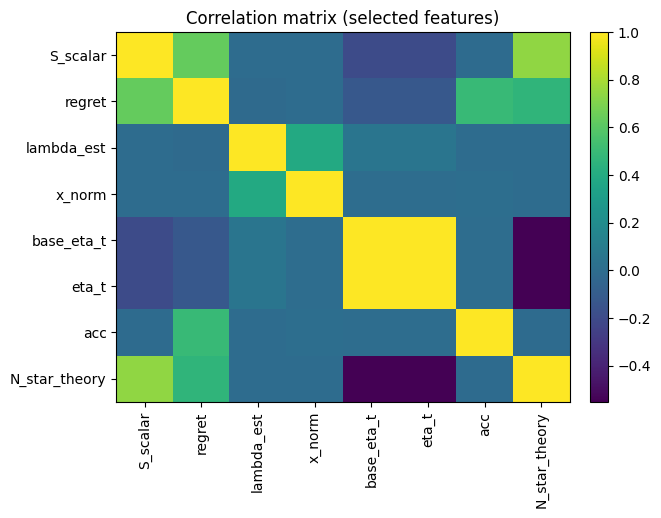

In [43]:
if selected:
    corr = df[selected].select_dtypes(include=[np.number]).corr()
    plt.figure()
    im = plt.imshow(corr, aspect="auto", interpolation="none")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(selected)), selected, rotation=90)
    plt.yticks(range(len(selected)), selected)
    plt.title("Correlation matrix (selected features)")
else:
    print("No selected features for correlation.")